# Estimating Obesity: A Study of Eating Habits and Physical Condition

Name: Caterina Gallo, Sophia Mares, William Acuna

Date: 02/27/23

In [5]:
# Libraries to be used

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import scipy.stats
from scipy.stats import anderson
from scipy.stats import beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

## Data Cleaning and Preparation

In this section, we access the datafile and save the variables. For each subject the body mass index is calculated and the obesity level is evaluated. 

In [ ]:
dataset = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv') # access and read data file 
print(dataset.head())
print('\n', dataset.tail())
gender = dataset['Gender'] # gender: Female or Male
age = dataset['Age'] # age [years]
height = dataset['Height'] # height [m]
weight = dataset['Weight'] # weight [kg]

# Eating habits attributes 
FAVC = dataset['FAVC'] # frequent consumption of high caloric food: yes or no
# FCVC: frequency of consumption of vegetables
FCVC = round(dataset['FCVC']).map({1: 'never', 2: 'sometimes', 3: 'always'}) # 1, 2, 3 are now subsituted by never, sometimes, and always, respectively
NCP = dataset['NCP'] # number of main meals: from 1 to 4
CAEC = dataset['CAEC'] # consumption of food between meals: no, sometimes, frequently, always
CH2O = dataset['CH2O'] # consumption of daily water: from 1 to 3 [l]
CALC = dataset['CALC'] # consumption of alcohol: no, sometimes, frequently, always
# Physical condition attributes
SCC = dataset['SCC'] # calories consumption monitoring: yes or no
FAF = dataset['FAF'] # physical activity frequency: from 0 to 5 days per week
TUE = dataset['TUE'] # time using technology: from 0 to 5 hours per day
MTRANS = dataset['MTRANS'] # transportation used: automobile, motorbike, bike, public transport, walking
# Other 
family_overweight = dataset['family_history_with_overweight'] # family history with overweight: yes or no
SMOKE = dataset['SMOKE'] # 

# Calculation of the body mass index and obesity level classification 
BMI = weight / np.power(height, 2) # body mass index [kg/m^2]
obesitylevel = np.empty(len(BMI)) # Underweight: 0, Normal: 1, Overweight: 2, Obesity I: 3, Obesity II: 4, Obesity III: 5
obesitylevel_bis = obesitylevel # Underweight: 0, Normal: 0, Overweight: 0, Obesity I: 1, Obesity II: 1, Obesity III: 1

for jj in range(len(BMI)): 
    if BMI[jj] < 18.5:
        obesitylevel[jj] = 0
        obesitylevel_bis[jj] = 0
    if BMI[jj] >= 18.5 and BMI[jj] < 24.9:
        obesitylevel[jj] = 1
        obesitylevel_bis[jj] = 0
    if BMI[jj] >= 24.9 and BMI[jj] < 29.9:
        obesitylevel[jj] = 2
        obesitylevel_bis[jj] = 0
    if BMI[jj] >= 29.9 and BMI[jj] < 34.9:
        obesitylevel[jj] = 3
        obesitylevel_bis[jj] = 1
    if BMI[jj] >= 34.9 and BMI[jj] < 39.9:
        obesitylevel[jj] = 4
        obesitylevel_bis[jj] = 1
    if BMI[jj] >= 39.9:
        obesitylevel[jj] = 5
        obesitylevel_bis[jj] = 1

obesitylevel_bisbis = obesitylevel_bis.tolist() # convert obesitylevel_bis into a list
obesitylevel_bisbis = pd.DataFrame(data = {'obesitylevel_bisbis': obesitylevel_bisbis}) # convert obesitylevel_bisbis into a dataframe
obesitylevel_bisbis = obesitylevel_bisbis['obesitylevel_bisbis'].map({1: 'yes', 0: 'no'}) # Underweight: no, Normal: no, Overweight: no, Obesity I: yes, Obesity II: yes, Obesity III: yes
        
NObeyesdad = dataset['NObeyesdad'] # obesity level as saved in the dataset

## Exploratory Data Analysis (i)

Descriptive statistics is shown below. Data are analyzed through stacked barplots and hystograms. 

In [ ]:
count_f = 0 # number of females
for jj in range(len(gender)):
    if gender[jj] == 'Female': 
        count_f = count_f + 1
count_m = len(gender) - count_f # number of males 
print('There are', count_f, 'females and', count_m, 'males.')

age_f = age.loc[dataset['Gender'] == 'Female'] # ages of females
age_m = age.loc[dataset['Gender'] == 'Male'] # ages of males
weight_f = weight.loc[dataset['Gender'] == 'Female'] # weights of females
weight_m = weight.loc[dataset['Gender'] == 'Male'] # weights of males
height_f = height.loc[dataset['Gender'] == 'Female'] # heights of females
height_m = height.loc[dataset['Gender'] == 'Male'] # heights of males
BMI_f = weight_f / np.power(height_f, 2) # BMI for females
BMI_m = weight_m / np.power(height_m, 2) # BMI for males

# Sample size, mean, standard deviation, and five number summary for age, weight, height variables for females 
summary_agef = age_f.describe() 
print('Summary age for females \n', round(summary_agef, 2))
summary_weightf = weight_f.describe() 
print('Summary weight for females \n', round(summary_weightf, 2))
summary_heightf = height_f.describe() 
print('Summary height for females \n', round(summary_heightf, 2))
summary_BMIf = BMI_f.describe() 
print('Summary BMI for females \n', round(summary_BMIf, 2))

# Sample size, mean, standard deviation, and five number summary for age, weight, height variables for males
summary_agem = age_m.describe() 
print('Summary age for males \n', round(summary_agem, 2))
summary_weightm = weight_m.describe() 
print('Summary weight for males \n', round(summary_weightm, 2))
summary_heightm = height_m.describe() 
print('Summary height for males \n', round(summary_heightm, 2))
summary_BMIm = BMI_m.describe() 
print('Summary BMI for males \n', round(summary_BMIm, 2))

# Visualization of distrubution of each variable 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,8))
plt.rcParams['font.size'] = '16'
FAVC.value_counts().plot(ax = ax1, kind = 'bar', xlabel = 'Frequent consumption of high caloric', ylabel = 'Frequency')
FCVC.value_counts().plot(ax = ax2, kind = 'bar', xlabel = 'Frequency of consumption of vegetables')
CAEC.value_counts().plot(ax = ax3, kind = 'bar', xlabel = 'Consumption of food between meals')
plt.savefig('Fig1.jpeg', bbox_inches='tight') 
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,8))
plt.rcParams['font.size'] = '16'
CALC.value_counts().plot(ax = ax1, kind = 'bar', xlabel = 'Consumption of alcohol')
SCC.value_counts().plot(ax = ax2, kind = 'bar', xlabel = 'Calories consumption monitoring', ylabel = 'Frequency')
MTRANS.value_counts().plot(ax = ax3, kind = 'bar', xlabel = 'Transportation used')
plt.savefig('Fig2.jpeg', bbox_inches='tight') 
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,8))
ax1.hist(NCP, density = True)
ax1.set_xlabel('Number of main meals')
ax2.hist(CH2O, density = True)
ax2.set_xlabel('Consumption of daily water')
ax3.hist(FAF, density = True)
ax3.set_xlabel('Physical activity frequency')
ax4.hist(TUE, density = True)
ax4.set_xlabel('Time using technology')
plt.savefig('Fig3.jpeg', bbox_inches='tight') 
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,8))
dataset.groupby(['NObeyesdad', 'Gender']).size().unstack().plot(ax = ax1, kind = 'bar', stacked = True, xlabel = 'Obesity level', ylabel = 'Frequency', title = 'By gender')
dataset.groupby(['NObeyesdad', 'family_history_with_overweight']).size().unstack().plot(ax = ax2, kind = 'bar', stacked = True, xlabel = 'Obesity level', title = 'By family history with overweight')
dataset.groupby(['NObeyesdad', 'SMOKE']).size().unstack().plot(ax = ax3, kind = 'bar', stacked = True, xlabel = 'Obesity level', title = 'By smoke')
# fig.suptitle('Relationships between obesity level and gender, family history and smoke ', fontsize = 14)
plt.savefig('Fig4.jpeg', bbox_inches='tight') 
plt.show()


## Exploratory Data Analysis (ii)

Biostatistics univariate tests are performed to evaluate the correlation between the obesity level and each eating habits and physical conditions attributes. As suggested by Chicco et al., the Anderson Darling test is performed, in order to verify if continuous eating habits and physical condition attributes are normally distributed. To evaluate the associations between categorical eating habits / physical conditions attributes and obesity level (categorical), we adopt the Chi-squared test of independance, while to evaluate associations between continuous eating habits / physical conditions attributes and obesity level (categorical), we use logistic regression. 


Reference: Chicco, D., & Jurman, G. (2020). Survuval prediction of patients with sepsis from age, sex, and septinc episode number alone. Scientific Report 10(1), Article 17156. https://doi.org/10.1038/s41598-020-73558-3 

In [ ]:
eating_habits_continuous = np.array([NCP, CH2O]) # continuous eating habits attributes
physical_conditions_continuous = np.array([FAF, TUE]) # countinuous physical conditions attributes
other_continuous = np.array([age, weight, height]) # other continuous attributes
lab_eating_habits_continuous = ['NCP', 'CH20'] # label continuous eating habits attributes
lab_physical_conditions_continuous = ['FAF', 'TUE'] # label continuous physical conditions attributes
lab_other_continuous = ['age', 'weight', 'height'] # label other continuous attributes

# Anderson Darling test to verify if continuous variables are normally distributed 
# Eating habits
for jj in range(len(eating_habits_continuous)):
    anderson_test = scipy.stats.anderson(eating_habits_continuous[jj])
    count_anderson = 0 
    index_anderson = 0
    significance_level_anderson = []
    for kk in range (len(anderson_test.critical_values)):
        if anderson_test.critical_values[kk] >= anderson_test.statistic:
            count_anderson = count_anderson + 1 
            significance_level_anderson[index_anderson] = kk
            index_anderson = index_anderson + 1
    if count_anderson == 0:
        print('The null hypothesis that', lab_eating_habits_continuous[jj], 'is normally distributed cannot be rejected')
    else:
        print('The null hypothesis that', lab_eating_habits_continuous[jj], 'is normally distributed may be rejected at the significance level of', round(min(index_anderson), 2))
# Physical conditions
for jj in range(len(physical_conditions_continuous)):
    anderson_test = scipy.stats.anderson(physical_conditions_continuous[jj])
    count_anderson = 0 
    index_anderson = 0
    significance_level_anderson = []
    for kk in range (len(anderson_test.critical_values)):
        if anderson_test.critical_values[kk] >= anderson_test.statistic:
            count_anderson = count_anderson + 1 
            significance_level_anderson[index_anderson] = kk
            index_anderson = index_anderson + 1
    if count_anderson == 0:
        print('The null hypothesis that', lab_physical_conditions_continuous[jj], 'is normally distributed cannot be rejected')
    else:
        print('The null hypothesis that', lab_physical_conditions_continuous[jj], 'is normally distributed may be rejected at the significance level of', round(min(index_anderson), 2))
# Other attributes
for jj in range(len(other_continuous)):
    anderson_test = scipy.stats.anderson(other_continuous[jj])
    count_anderson = 0 
    index_anderson = 0
    significance_level_anderson = []
    for kk in range (len(anderson_test.critical_values)):
        if anderson_test.critical_values[kk] >= anderson_test.statistic:
            count_anderson = count_anderson + 1 
            significance_level_anderson[index_anderson] = kk
            index_anderson = index_anderson + 1
    if count_anderson == 0:
        print('The null hypothesis that', lab_other_continuous[jj], 'is normally distributed cannot be rejected')
    else:
        print('The null hypothesis that', lab_other_continuous[jj], 'is normally distributed may be rejected at the significance level of', round(min(index_anderson), 2))
        
# Chi-squared tests of independence to evaluate the associations between categorical eating habits / physical conditions attributes and obesity level (categorical)
label_obesitylevel_bisbis = ['yes', 'no']

# FAVC and obesity level
label_FAVC = ['yes', 'no']
table_FAVC = pd.crosstab(FAVC, obesitylevel_bisbis, normalize = 'index')
table_FAVC.index = label_FAVC
table_FAVC.columns = label_obesitylevel_bisbis
# print('Contingency Table (FAVC, obesitylevel_bisbis): \n', table_FAVC)
table_FAVC = sm.stats.Table(table_FAVC)
print('Chi-squared test of independence (FAVC, obesitylevel_bisbis), p-value: \n', round(table_FAVC.test_nominal_association().pvalue, 3))

# FCVC and obesity level
label_FCVC = ['never', 'sometimes', 'always']
table_FCVC = pd.crosstab(FCVC, obesitylevel_bisbis, normalize = 'index')
table_FCVC.index = label_FCVC
table_FCVC.columns = label_obesitylevel_bisbis
# print('Contingency Table (FCVC, obesity_level_bisbis): \n', table_FCVC)
table_FCVC = sm.stats.Table(table_FCVC)
print('Chi-squared test of independence (FCVC, obesitylevel), p-value: \n', round(table_FCVC.test_nominal_association().pvalue, 3))

# CAEC and obesity level
label_CAEC = ['no', 'sometimes', 'frequently', 'always']
table_CAEC = pd.crosstab(CAEC, obesitylevel_bisbis, normalize = 'index')
table_CAEC.index = label_CAEC
table_CAEC.columns = label_obesitylevel_bisbis
# print('Contingency Table (CAEC, obesitylevel_bisbis): \n', table_CAEC)
table_CAEC = sm.stats.Table(table_CAEC)
print('Chi-squared test of independence (CAEC, obesitylevel_bisbis), p-value: \n', round(table_CAEC.test_nominal_association().pvalue, 3))

# CALC and obesity level
label_CALC = ['no', 'sometimes', 'frequently', 'always']
table_CALC = pd.crosstab(CALC, obesitylevel_bisbis, normalize = 'index')
table_CALC.index = label_CALC
table_CALC.columns = label_obesitylevel_bisbis
# print('Contingency Table (CALC, obesitylevel_bisbis): \n', table_CALC)
table_CALC = sm.stats.Table(table_CALC)
print('Chi-squared test of independence (CALC, obesitylevel_bisbis), p-value: \n', round(table_CALC.test_nominal_association().pvalue, 3))

# SCC and obesity level
label_SCC = ['yes', 'no']
table_SCC = pd.crosstab(SCC, obesitylevel_bisbis, normalize = 'index')
table_SCC.index = label_SCC
table_SCC.columns = label_obesitylevel_bisbis
# print('Contingency Table (SCC, obesitylevel_bisbis): \n', table_SCC)
table_SCC = sm.stats.Table(table_SCC)
print('Chi-squared test of independence (SCC, obesitylevel_bisbis), p-value: \n', round(table_SCC.test_nominal_association().pvalue, 3))

# MTRANS and obesity level
label_MTRANS = ['automobile', 'motorbike', 'bike', 'public transport', 'walking']
table_MTRANS = pd.crosstab(MTRANS, obesitylevel_bisbis, normalize = 'index')
table_MTRANS.index = label_MTRANS
table_MTRANS.columns = label_obesitylevel_bisbis
# print('Contingency Table (MTRANS, obesitylevel_bisbis): \n', table_MTRANS)
table_MTRANS = sm.stats.Table(table_MTRANS)
print('Chi-squared test of independence (MTRANS, obesitylevel_bisbis), p-value: \n', round(table_MTRANS.test_nominal_association().pvalue, 3))

# family_overweight and obesity level
label_family_overweight = ['yes', 'no']
table_family_overweight = pd.crosstab(family_overweight, obesitylevel_bisbis, normalize = 'index')
table_family_overweight.index = label_family_overweight
table_family_overweight.columns = label_obesitylevel_bisbis
# print('Contingency Table (family_overweight, obesitylevel_bisbis): \n', table_family_overweight)
table_family_overweight = sm.stats.Table(table_family_overweight)
print('Chi-squared test of independence (family_overweight, obesitylevel_bisbis), p-value: \n', round(table_family_overweight.test_nominal_association().pvalue, 3))

# SMOKE and obesity level
label_SMOKE = ['yes', 'no']
table_SMOKE = pd.crosstab(SMOKE, obesitylevel_bisbis, normalize = 'index')
table_SMOKE.index = label_SMOKE
table_SMOKE.columns = label_obesitylevel_bisbis
# print('Contingency Table (SMOKE, obesitylevel_bisbis): \n', table_SMOKE)
table_SMOKE = sm.stats.Table(table_SMOKE)
print('Chi-squared test of independence (SMOKE, obesitylevel_bisbis), p-value: \n', round(table_SMOKE.test_nominal_association().pvalue, 3))

# gender and obesity level
label_gender = ['Female', 'Male']
table_gender = pd.crosstab(gender, obesitylevel_bisbis, normalize = 'index')
table_gender.index = label_gender
table_gender.columns = label_obesitylevel_bisbis
# print('Contingency Table (gender, obesitylevel_bisbis): \n', table_gender)
table_gender = sm.stats.Table(table_gender)
print('Chi-squared test of independence (gender, obesitylevel_bisbis), p-value: \n', round(table_gender.test_nominal_association().pvalue, 3))

# Logistic regression to evaluate the associations between continuous eating habits / physical conditions attributes and obesity level (categorical)

# NCP and obesity level 
data_NCP_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'NCP': NCP})
fit_NCP = smf.glm('obesitylevel_bis ~ NCP', family = sm.families.Binomial(), data = data_NCP_obesity).fit()
print('Generalized linear model regression results (NCP, obesitylevel_bis): \n', fit_NCP.pvalues)

# CH20 and obesity level 
data_CH20_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'CH20': CH2O})
fit_CH20 = smf.glm('obesitylevel_bis ~ CH20', family = sm.families.Binomial(), data = data_CH20_obesity).fit()
print('Generalized linear model regression results (CH20, obesitylevel_bis): \n', fit_CH20.pvalues)

# FAF and obesity level 
data_FAF_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'FAF': FAF})
fit_FAF = smf.glm('obesitylevel_bis ~ FAF', family = sm.families.Binomial(), data = data_FAF_obesity).fit()
print('Generalized linear model regression results (FAF, obesitylevel_bis): \n', fit_FAF.pvalues)

# TUE and obesity level 
data_TUE_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'TUE': TUE})
fit_TUE = smf.glm('obesitylevel_bis ~ TUE', family = sm.families.Binomial(), data = data_TUE_obesity).fit()
print('Generalized linear model regression results (TUE, obesitylevel_bis): \n', fit_TUE.pvalues)

# age and obesity level 
data_age_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'age': age})
fit_age = smf.glm('obesitylevel_bis ~ age', family = sm.families.Binomial(), data = data_age_obesity).fit()
print('Generalized linear model regression results (age, obesitylevel_bis): \n', fit_age.pvalues)

# weight and obesity level 
data_weight_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'weight': weight})
fit_weight = smf.glm('obesitylevel_bis ~ weight', family = sm.families.Binomial(), data = data_weight_obesity).fit()
print('Generalized linear model regression results (weight, obesitylevel_bis): \n', fit_weight.pvalues)

# height and obesity level 
data_height_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'height': height})
fit_height = smf.glm('obesitylevel_bis ~ height', family = sm.families.Binomial(), data = data_height_obesity).fit()
print('Generalized linear model regression results (height, obesitylevel_bis): \n', fit_height.pvalues)

## Model Selection

(i) This block of code gives us a linear regression model (by using the command LinearRegression()) for our independent variable NObeyesdad, which is a categorical variable with 6 categories. It uses each important dependent variable identified in the previous paragraph.

In [ ]:
##WILL A: I recommend not using this and instead using the GLM 0001111 (binary) model
df = dataset

# Define the features and target variable
num_cols = ['Age', 'CH2O', 'FAF', 'TUE']
target_col = 'NObeyesdad'

# X and Y
X = df[num_cols]
Y = df[target_col]
le = LabelEncoder()
y = le.fit_transform(Y)
target_col_encoded = le.classes_

# Initialize and fit linear regression model
lr = LinearRegression()
lr.fit(X, y)

# Print coefficients
coefficients = pd.DataFrame({
    'Features': list(X.columns),
    'Coefficients': lr.coef_
})
print(coefficients)
print('\nTarget variable categories: ', list(target_col_encoded))


(ii) This block of code gives us a linear regression model (by using Logistic Regression, logit link with binary data) for our independent variable NObeyesdad, which is a categorical variable with 6 categories. It uses each important dependent variable identified in the previous paragraph.

In [ ]:
### To eliminate, we are using a Binomial family - dependent variable is binary

# Define the features and target variable
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'CALC', 'MTRANS']
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
target_col = 'NObeyesdad'

encoder = OneHotEncoder(sparse=False)
cat_data = encoder.fit_transform(df[cat_cols])
cat_cols_encoded = list(encoder.get_feature_names_out(cat_cols))

# Combine categorical and numeric variables
X = pd.concat([pd.DataFrame(cat_data, columns=cat_cols_encoded), df[num_cols]], axis=1)

# Define the features and target variable
label = [0, 1, 2, 3, 4, 5, 6]
y = df['NObeyesdad'].replace(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], label)

# Fit a binomial GLM
model = sm.GLM(y, sm.add_constant(X), family=sm.families.Binomial())
result = model.fit()

# Print the model summary
print(result.summary())

(iii) This block builds off of the last one, however, in order to use a GLM fit, it replaces our indepdent variable categories: 'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' with 0,0,0,1,1,1,1 values.

In [10]:
# Define the features and target variable

from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'CALC', 'MTRANS']
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
target_col = 'NObeyesdad'

encoder = OneHotEncoder(sparse=False)
cat_data = encoder.fit_transform(df[cat_cols])
cat_cols_encoded = list(encoder.get_feature_names_out(cat_cols))

# Combine categorical and numeric variables
X = pd.concat([pd.DataFrame(cat_data, columns=cat_cols_encoded), df[num_cols]], axis=1)

label = [0, 0, 1, 1, 1, 1, 1]
y = df['NObeyesdad'].replace(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], label)

# Fit a binomial GLM
model = sm.GLM(y, sm.add_constant(X), family=sm.families.Binomial())
result = model.fit()

# Print the model summary
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             NObeyesdad   No. Observations:                 2111
Model:                            GLM   Df Residuals:                     2088
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17.101
Date:                Sat, 25 Feb 2023   Deviance:                       34.203
Time:                        14:36:09   Pearson chi2:                 4.30e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.6801
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

C:\Users\willa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\willa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


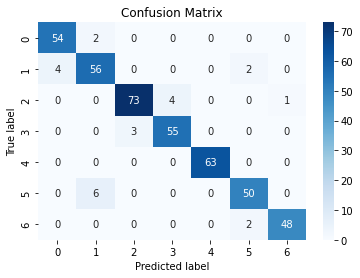

In [9]:
#BLOCK 7 STARTS
"""
Decision tree for this dataset - Including all variables
"""

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

#print(df.head())

# Define the target variable and input features
y = df['NObeyesdad']
#X = df.drop(['NObeyesdad', 'Weight', 'Height'], axis=1)
X = df.drop('NObeyesdad', axis=1)
print(df.head())

# One-hot encode categorical variables
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
enc = OneHotEncoder(sparse=False, drop='first')
X_cat = enc.fit_transform(X[cat_cols])
X_num = X.drop(cat_cols, axis=1)
X = pd.concat([pd.DataFrame(X_cat), X_num], axis=1)

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Predict the target variable on the testing set
y_pred = dtc.predict(X_test)

# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")

# add axis labels and title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# show plot
plt.show()

#BLOCK 7 ENDS

In [ ]:
#BLOCK 9 STARTS
"""
Decision tree for this dataset - Additionally, excluding weight
"""

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

# Define the target variable and input features
y = df['NObeyesdad']
X = df.drop(['NObeyesdad', 'Weight'], axis=1)
#X = df.drop('NObeyesdad', axis=1)
#print(df.head())

# One-hot encode categorical variables
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
enc = OneHotEncoder(sparse=False, drop='first')
X_cat = enc.fit_transform(X[cat_cols])
X_num = X.drop(cat_cols, axis=1)
X = pd.concat([pd.DataFrame(X_cat), X_num], axis=1)

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Predict the target variable on the testing set
y_pred = dtc.predict(X_test)

# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")

# add axis labels and title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# show plot
plt.show()
#BLOCK 9 ENDS

In [8]:
#TO DELETE
"""
**Work in Progress**

The intent of this block is to run an analysis of variance (ANOVA) model to determine if we should reject the null hypothesis
 and accept the alternate hypothesis, or visa versa. This is an effective way to determine whether there is a difference 
 among the experiement's results. 
"""
# Fit the data for the ANOVA test versus obesity level. 
fit_all = smf.ols(formula = "obesitylevel ~ C(family_history_with_overweight) + C(FAVC) + C(CAEC) + C(SMOKE) + C(CALC) + C(MTRANS) + Age + Weight + FCVC + NCP + CH2O + FAF + TUE", data = dataset).fit()
print(fit_all.summary())

NameError: name 'dataset' is not defined

In [ ]:
#TO DELETE
# Fit the categorical data for the ANOVA test versus obesity level. 
fit_cat = smf.ols(formula = "obesitylevel ~ C(family_history_with_overweight) + C(FAVC) + C(CAEC) + C(SMOKE) + C(CALC) + C(MTRANS)", data = dataset).fit()
print(fit_cat.summary())

In [ ]:
#TO DELETE
# Fit the numerical data for the ANOVA test versus obesity level. 
fit_num = smf.ols(formula = "obesitylevel ~ Age + Weight + FCVC + NCP + CH2O + FAF + TUE", data = dataset).fit()
print(fit_num.summary())

## Model Analysis 